# Evaluate an plot the results of the model

## Load packages and data

In [8]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from pathlib import Path
from itertools import product
project_root = (
    Path.cwd()
    .parents[0]
)
sys.path.append(str(project_root))
sys.path.append(str(f'{project_root}/run-simulation/py-files'))
from utils_calibration import calibrate_propensity_score, compute_ipw_estimate, calibration_errors
from utils_dgps import dgp_wrapper
from utils_eval import plot_dist, plot_calibration_metrics, plot_ate_metrics, plot_overlap_ratio, plot_calibration_comparison
from utils_eval import plot_ps_treatment_comparison, plot_overlap_comparison, plot_mirrored_propensity_histogram, evaluate_estimation, add_headers, plot_overlap_ratio_detailed

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

In [5]:
# Treatment Effect:
n_obs = 1000000
overlap = 0
R2_d = 0
share_treated = 0.1
dim_x = 20
overlap = 0

dgp_dict = {
    'n_obs':n_obs,
    'share_treated': share_treated}

dgp_type = 'sim_v06_unbalanced' 
data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

ate = data_dict['treatment_effect']

print(f'True Treatment Effect, Setting 1 Simulation Unbalanced: {ate}')

True Treatment Effect, Setting 1 Simulation Unbalanced: 1.0000903670263763


In [98]:
df=pd.read_pickle('results/results_unbalanced.pkl')
dgp_type = 'sim_v06_unbalanced'
df=pd.DataFrame(df)
df.head()
window_size = 1.5
theta = 1
sigma = 1 # 5
sim_type = 'A'
dim_x = 20
df['R2_d'] = 0  
df['dim_x'] = dim_x  
df['overlap'] = 0  

## Basic Overview

In [99]:
grouping_columns = ["n_obs", "R2_d", "dim_x", "learner_g", "learner_m", "method", "calib_method", "clipping_threshold", "overlap", "share_treated"]
df.groupby(grouping_columns).mean()

coefs  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated              
2000  0    20    LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0       0.05          -41.154631   
                                                                                                0.10            0.536035   
                                                                                                0.20            0.944845   
                                                                     1.000000e-02       0       0.05            0.985645   
                                                                                                0.10            1.033897   
...                                                                                                                  ...   
8000  0    20    RF        RF        oracle             uncalibrated 1.000000e-02       0       0.10            1.002139   
                                                                                                0.20            0.997943   
                                                                     1.000000e-01       0       0.05            1.037713   
                                                                                                0.10            1.013332   
                                                                                                0.20            0.997943   

                                                                                                                      ses  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated               
2000  0    20    LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0       0.05           121.009729   
                                                                                                0.10             5.634470   
                                                                                                0.20             0.519868   
                                                                     1.000000e-02       0       0.05             0.581071   
                                                                                                0.10             0.651339   
...                                                                                                                   ...   
8000  0    20    RF        RF        oracle             uncalibrated 1.000000e-02       0       0.10             0.040329   
                                                                                                0.20             0.029940   
                                                                     1.000000e-01       0       0.05             0.029634   
                                                                                                0.10             0.035863   
                                                                                                0.20             0.029940   

                                                                                                               cover  \
n_obs R2_d dim_x learner_g learner_m method             calib_method clipping_threshold overlap share_treated          
2000  0    20    LGBM      LGBM      alg-1-uncalibrated uncalibrated 1.000000e-12       0       0.05            0.97   
                                                                                                0.10            0.97   
                                                                                                0.20            0.99   
                                                                     1.000000e-02       0       0.05            1.00   
                                                                                                0.10            1.00   
...                                 

## Unique Values

In [100]:
df= df.sort_values(by=["n_obs","dim_x","clipping_threshold"])
for col in grouping_columns:
    print(f"{col}: {df[col].unique()}")

n_obs: [2000 4000 6000 8000]
R2_d: [0]
dim_x: [20]
learner_g: ['Linear' 'RF' 'LGBM']
learner_m: ['Logit' 'RF' 'LGBM']
method: ['alg-1-uncalibrated' 'alg-2-nested-cross-fitting-calib'
 'alg-3-cross-fitted-calib' 'alg-4-single-split-calib'
 'alg-5-full-sample-calib' 'oracle']
calib_method: ['uncalibrated' 'isotonic' 'platt' 'ivap']
clipping_threshold: [1.e-12 1.e-02 1.e-01]
overlap: [0]
share_treated: [0.05 0.1  0.2 ]


In [101]:
df_results = pd.DataFrame(columns=[
    'n_obs', 'R2_d', 'dim_x', 'learner_g', 'learner_m', 'method','calib_method', 
    'clipping_threshold', 'rmses', 'K', 'ece_u', 'ece_q', 'ece_u_5', 'ece_q_5', 
    'ece_l2','mce','procedure', 'estimate', 'overlap', 'share_treated'
])

In [102]:
df= df.rename(columns={"coefs": "IRM"})
df= df.rename(columns={"ipw_coefs": "IPW"})
df= df.rename(columns={"plr_coefs": "PLR"})

# filter DataFrame

for calib_method in enumerate(["uncalibrated", "isotonic", "ivap", "oracle", "platt"]):
    df_new = df[df["calib_method"].isin(calib_method)]

    # melt DataFrame for plotting
    grouping_columns = ["n_obs", "dim_x", "R2_d", "learner_g", "learner_m", "method", "calib_method", "clipping_threshold", 
                        "rmses", "K","ece_u","ece_q","ece_u_5","ece_q_5","ece_l2","mce", "overlap", "share_treated"]
    df_new = df_new.melt(
        id_vars=grouping_columns,
        value_vars=["IRM", "IPW", "PLR"],
        var_name="procedure",
        value_name="estimate")

    df_results = pd.concat([df_results, df_new], ignore_index=True)

In [103]:
method_mapping = {
    "alg-1-uncalibrated": "Alg-1-uncalib",
    "alg-2-nested-cross-fitting-calib": "Alg-2-nested-cf",
    "alg-3-cross-fitted-calib": "Alg-3-cf",
    "alg-4-single-split-calib": "Alg-4-single-split",
    "alg-5-full-sample-calib": "Alg-5-full-sample",
    "oracle": "Oracle"
}
df_results["method"] = df_results["method"].replace(method_mapping)
calib_mapping = {
    "uncalibrated": "Uncalib",
    "isotonic": "Iso",
    "platt": "Platt",
    "ivap": "IVAP"}
df_results["calib_method"] = df_results["calib_method"].replace(calib_mapping)
df_results.insert(1, "Method", df_results[['method','calib_method']].agg('-'.join, axis=1))

In [104]:
# fixed values
overlap = 0
share_treated = 0.1
R2_d = 0

dgp_type = 'sim_v06_unbalanced'
n_obs = 4000
clipping_threshold = 0.01
learner_g = "LGBM"
learner_m = "LGBM"

n_obs_list = [2000, 4000, 6000]
overlap_list = [0]
R2_d_list = [0]
share_treated_list = [0.05, 0.1, 0.2]


clipping_thresholds = [1e-12, 0.01, 0.1]
learner_dict_g = {'Linear','LGBM','RF'}
learner_dict_m = {'Logit','LGBM', 'RF'}

In [105]:
# Filter cali method
df= df_results.copy()
calib_methods=["Uncalib", "Iso"]#, "ivap", "oracle", "platt"]
df = df[df["calib_method"].isin(calib_methods)]

Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df.loc[:, "Method"] = df["Method"].replace(Method_mapping)

df= df.sort_values(by=["procedure","Method"])

## Distribution of Estimates

In [106]:
common_params = {
    'df': df,
    'theta': theta,
    'window_size': window_size
}

# 1) Learner_m plot
plot_dist(
    directory='results/figures_unb/learner_m/',
    varying_col='learner_m',
    fixed_conditions={
        'n_obs': n_obs,
        'dim_x': dim_x,
        'learner_g': learner_g,
        'clipping_threshold': clipping_threshold,
        'overlap': overlap,
        'R2_d': R2_d,
        'share_treated': share_treated
    },
    **common_params
)

# 2) Learner_g plot
plot_dist(
    directory='results/figures_unb/learner_g/',
    varying_col='learner_g',
    fixed_conditions={
        'n_obs': n_obs,
        'dim_x': dim_x,
        'learner_m': learner_m,
        'clipping_threshold': clipping_threshold,
        'overlap': overlap,
        'R2_d': R2_d,
        'share_treated': share_treated
    },
    **common_params
)

# 3) n_obs plot
plot_dist(
    directory='results/figures_unb/n_obs/',
    varying_col='n_obs',
    fixed_conditions={
        'dim_x': dim_x,
        'learner_g': learner_g,
        'learner_m': learner_m,
        'clipping_threshold': clipping_threshold,
        'overlap': overlap,
        'R2_d': R2_d,
        'share_treated': share_treated
    },
    varying_filter=n_obs_list,
    filename_zero_fmt='05d',
    **common_params
)

# 4) Clipping threshold plot
plot_dist(
    directory='results/figures_unb/clipping_threshold/',
    varying_col='clipping_threshold',
    fixed_conditions={
        'n_obs': n_obs,
        'dim_x': dim_x,
        'learner_g': learner_g,
        'learner_m': learner_m,
        'overlap': overlap,
        'R2_d': R2_d,
        'share_treated': share_treated
    },
    **common_params
)

# 5) Share treated plot
plot_dist(
    directory='results/figures_unb/share_treated/',
    varying_col='share_treated',
    fixed_conditions={
        'n_obs': n_obs,
        'dim_x': dim_x,
        'learner_g': learner_g,
        'learner_m': learner_m,
        'clipping_threshold': clipping_threshold,
        'overlap': overlap,
        'R2_d': R2_d,
    },
    varying_filter=share_treated_list,
    filename_zero_fmt='05d',
    **common_params
)

## Graphs: Treatment and Calibration Errors by Sample Size and Dimension

In [110]:
df = df_results.copy()
df["bias"]= df["estimate"]-theta
Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df["Method"] = df["Method"].replace(Method_mapping)
groupby_cols = ['n_obs', 'dim_x', 'R2_d', 'learner_g', 
                'learner_m', 'clipping_threshold', 
                'procedure', 'Method', 'overlap', 
                'share_treated']

# Columns to calculate the mean from
mean_cols = ['ece_q', 'ece_q_5', 'ece_u', 'ece_u_5', 'ece_l2', 'mce']
mean_results = df.groupby(groupby_cols)[mean_cols].mean().reset_index()

# Prepare the calibration errors DataFrame
calib_errors = mean_results.rename(columns={"ece_q": "ECE Quantile (b=10)"})
calib_errors['ECE Quantile (b=5)'] = mean_results['ece_q_5']
calib_errors['ECE Uniform (b=10)'] = mean_results['ece_u']
calib_errors['ECE Uniform (b=5)'] = mean_results['ece_u_5']
calib_errors['L2-CE Uniform (b=10)'] = mean_results['ece_l2']
calib_errors['MCE Uniform (b=10)'] = mean_results['mce']

# Replace clipping_threshold values for readability
calib_errors['clipping_threshold'] = calib_errors['clipping_threshold'].replace({
    1.e-12: 'Unclipped', 
    1.e-2: 'Clipped_0.01', 
    1.e-1: 'Clipped_0.1'
})
calib_errors['Method_Clip']= calib_errors[['Method','clipping_threshold']].agg('-'.join, axis=1)
calib_errors = calib_errors.sort_values(["Method_Clip","n_obs","R2_d","overlap","share_treated","dim_x","learner_g","learner_m"])

#### Plot Calibration Errors

In [111]:
# fixed values
learner_g = "LGBM"
dim_x = 20
R2_d_list = [0]
R2_d = 0
share_treated = 0.1
overlap = 0

overlap_list = [0]
n_obs_list = [2000,4000,6000,8000]
clipping_thresholds = [0.01, 0.1]
learner_dict_m = {'Logit','LGBM','RF'}

In [112]:
# Configuration for metrics
METRICS_CONFIG = [
    {'column': 'ECE Uniform (b=5)', 'ylabel': 'ECE Uniform (bins=5)'},
    {'column': 'ECE Uniform (b=10)', 'ylabel': 'ECE Uniform (bins=10)'},
    {'column': 'ECE Quantile (b=5)', 'ylabel': 'ECE Quantile (bins=5)'},
    {'column': 'ECE Quantile (b=10)', 'ylabel': 'ECE Quantile (bins=10)'},
    {'column': 'L2-CE Uniform (b=10)', 'ylabel': 'L2-CE Uniform (bins=10)'},
    {'column': 'MCE Uniform (b=10)', 'ylabel': 'MCE Uniform (bins=10)'}
]
methods = ['Alg-1-Uncalib-Unclipped','Alg-2-nested-cf-Iso-Unclipped', 'Alg-3-cf-Iso-Unclipped',
        'Alg-4-single-split-Iso-Unclipped', 'Alg-5-full-sample-Iso-Unclipped']

clipping_thresholds=[1e-12]

plot_calibration_metrics(
    directory='results/figures_unb/calib_errors/',
    data=calib_errors,
    n_obs_list=n_obs_list,
    dim_x=dim_x,
    learner_g=learner_g,
    clipping_thresholds=clipping_thresholds,
    learner_dict_m=learner_dict_m,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    metrics_config=METRICS_CONFIG,
    palette_colors=['#018571', "#252525", "#091e75", "#662506", "#850157", "#5c5c5c"],
    panel_labels=True,
    methods=methods,
)

### Plot treatment effect metrics

In [113]:
df_eval = df.groupby(['n_obs', 'dim_x', 'R2_d', 'learner_g', 'learner_m', 
                      'clipping_threshold', 'procedure', 'Method', 
                      'overlap', 'share_treated']
                    ).estimate.apply(lambda x: evaluate_estimation(x, theta=theta)).reset_index()
column_to_rename = df_eval.columns[-2]
df_eval = df_eval.rename(columns={column_to_rename: "Metrics"})

In [114]:
n_obs_list = [2000,4000,6000,8000]
dim_x_list = [20]
share_treated = 0.1
R2_d_list = [0]
overlap_list = [0]

share_treated_list = [0.05, 0.1, 0.2]

clipping_thresholds = [1e-12, 0.01, 0.1]
learner_dict_g = ['Linear', 'LGBM', 'RF']
learner_dict_m = ['Logit', 'LGBM', 'RF']
procedure_list = ['IPW', 'IRM', 'PLR']

results = pd.DataFrame(columns=['MAE', 'Mean Bias', 'RMSE', 'Std. dev.', 'n_obs', 'dim_x', 
                                'R2_d', 'procedure', 'Method', 'overlap', 'share_treated'])


for n_obs, clipping_threshold, learner_g, learner_m, procedure, dim_x, overlap, share_treated in product(
    n_obs_list, clipping_thresholds, learner_dict_g, learner_dict_m, procedure_list, dim_x_list, overlap_list, share_treated_list):
    
    # Filter data based on current parameter combination
    df_eval_new = df_eval[
        (df_eval['n_obs'] == n_obs) &
        (df_eval['clipping_threshold'] == clipping_threshold) &
        (df_eval['learner_m'] == learner_m) &
        (df_eval['procedure'] == procedure) &
        (df_eval['dim_x'] == dim_x) &
        (df_eval['R2_d'] == R2_d) &
        (df_eval['learner_g'] == learner_g) &
        (df_eval["overlap"] == overlap) & 
        (df_eval["share_treated"] == share_treated)
    ]

    # Pivot and format the new DataFrame
    df_eval_new = df_eval_new.pivot_table('estimate', ['Method'], 'Metrics').iloc[:, 0:4]
    df_eval_new = df_eval_new.assign(n_obs=n_obs, learner_g=learner_g, learner_m=learner_m,
                                     procedure=procedure, dim_x=dim_x, R2_d=R2_d,
                                     clipping_threshold=clipping_threshold, overlap=overlap,
                                     share_treated=share_treated, Method=df_eval_new.index)

    # Append to results
    results = pd.concat([results, df_eval_new], ignore_index=True)

# Replace clipping thresholds
results['clipping_threshold'] = results['clipping_threshold'].replace(
    {1.e-12: 'Unclipped', 0.01: 'Clipped_0.01', 0.1: 'Clipped_0.1'})

# Add 'Method_Clip' column
results.insert(1, "Method_Clip", results[['Method', 'clipping_threshold']].agg('-'.join, axis=1))
# For correct matches in legend
results = results.sort_values(["Method_Clip","n_obs","R2_d","overlap","share_treated","dim_x","learner_g","learner_m"])

In [128]:
pal = ['#018571', "#252525","#091e75", "#662506", "#850157", "#5c5c5c"]
sns.set_theme(style="whitegrid", context="paper")

share_treated = 0.1
R2_d_list = [0]
overlap = 0
clipping_thresholds = [0.01, 0.1]
learner_g = "LGBM"
clipping_threshold = 0.01

In [136]:
procedures = ['IPW', 'IRM', 'PLR']
metrics = ['RMSE', 'MAE', 'Std. dev.']

# Configuration for different plot types
CONFIG_1 = {
    'methods': [
        f'Alg-1-Uncalib-Clipped_{clipping_threshold}',
        'Alg-1-Uncalib-Unclipped',
        f'Alg-3-cf-Iso-Clipped_{clipping_threshold}',
        'Alg-3-cf-Iso-Unclipped',
        f'Alg-3-cf-IVAP-Clipped_{clipping_threshold}',
        'Alg-3-cf-Platt-Unclipped'
    ],
    'labels': [
        'Alg-1-clipped',
        'Alg-1-uncalib',
        'Alg-3-cf-Iso-Clipped',
        'Alg-3-cf-Iso',
        'Alg-3-cf-IVAP-Clipped',
        'Alg-3-cf-Platt'
    ]
}

# First plot type
plot_ate_metrics(
    directory_base='results/figures_unb/ate_errors_alg_3_',
    data=results,
    procedures=procedures,
    metrics=metrics,
    methods_config=CONFIG_1,
    learner_m_list=['LGBM'],
    clipping_threshold=clipping_threshold,
    n_obs_list=n_obs_list,
    dim_x=dim_x,
    learner_g=learner_g,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    palette_colors=['#018571', "#252525", "#091e75", "#662506", "#850157", "#5c5c5c"],
    fig_size=(14, 12),
    style_kwargs={
        'title_size': 18,
        'label_size': 16,
        'tick_size': 12,
        'panel_label_size': 18,
        'marker_size': 12
    },
    add_headers_func=add_headers
)

In [130]:
# Second plot type
CONFIG_2 = {
    'methods': [
        f'Alg-1-Uncalib-Clipped_{clipping_threshold}',
        f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}',
        'Alg-3-cf-Iso-Unclipped',
        f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}',
        'Alg-5-full-sample-Iso-Unclipped'
    ],
    'labels': [
        'Alg-1-clipped',
        'Alg-2-nested-cf-Iso-Clipped',
        'Alg-3-cf-Iso',
        'Alg-4-single-split-Iso-Clipped',
        'Alg-5-full-sample-Iso'
    ]
}
plot_ate_metrics(
    directory_base='results/figures_unb/ate_errors_',
    data=results,
    procedures=procedures,
    metrics=metrics,
    methods_config=CONFIG_2,
    learner_m_list=['LGBM'],
    clipping_threshold=clipping_threshold,
    n_obs_list=n_obs_list,
    dim_x=dim_x,
    learner_g=learner_g,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    palette_colors=['#018571', "#252525", "#091e75", "#662506", "#850157"],
    fig_size=(14, 12),
    style_kwargs={
        'title_size': 18,
        'label_size': 16,
        'tick_size': 12,
        'panel_label_size': 18,
        'marker_size': 12
    },
    add_headers_func=add_headers
)

In [131]:
clipping_threshold = 0.01
share_treated = 0.1

In [135]:
# Second plot type
CONFIG_3 = {
    'methods': [
        f'Alg-1-Uncalib-Clipped_{clipping_threshold}',
        f'Alg-2-nested-cf-Iso-Clipped_{clipping_threshold}',
        f'Alg-3-cf-Iso-Unclipped',
        f'Alg-4-single-split-Iso-Clipped_{clipping_threshold}',
        f'Alg-5-full-sample-Iso-Unclipped'
    ],
    'labels': [
        'Alg-1-clipped',
        'Alg-2-nested-cf-Iso-Clipped',
        'Alg-3-cf-Iso',
        'Alg-4-single-split-Iso-Clipped',
        'Alg-5-full-sample-Iso'
    ]
}
plot_ate_metrics(
    directory_base='results/figures_unb/ate_errors_2_',
    data=results,
    procedures=procedures,
    metrics=metrics,
    methods_config=CONFIG_3,
    learner_m_list=['LGBM'],
    clipping_threshold=clipping_threshold,
    n_obs_list=n_obs_list,
    dim_x=dim_x,
    learner_g=learner_g,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    palette_colors=['#018571', "#252525", "#091e75", "#662506", "#850157"],
    fig_size=(14, 12),
    style_kwargs={
        'title_size': 18,
        'label_size': 16,
        'tick_size': 12,
        'panel_label_size': 18,
        'marker_size': 12
    },
    add_headers_func=add_headers
)

In [134]:
# Second plot type
CONFIG_4 = {
    'methods': [
        f'Alg-1-Uncalib-Unclipped',
        f'Alg-1-Uncalib-Clipped_0.01',
        f'Alg-3-cf-Iso-Clipped_0.01',
        f'Alg-3-cf-Iso-Clipped_0.1',
        f'Alg-3-cf-Iso-Unclipped'
    ],
    'labels': [
        'Alg-1-clipped',
        'Alg-2-nested-cf-Iso-Clipped',
        'Alg-3-cf-Iso',
        'Alg-4-single-split-Iso-Clipped',
        'Alg-5-full-sample-Iso'
    ]
}
plot_ate_metrics(
    directory_base='results/figures_unb/ate_errors_3_',
    data=results,
    procedures=procedures,
    metrics=metrics,
    methods_config=CONFIG_4,
    learner_m_list=['LGBM'],
    clipping_threshold=clipping_threshold,
    n_obs_list=n_obs_list,
    dim_x=dim_x,
    learner_g=learner_g,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    palette_colors=['#018571', "#252525", "#091e75", "#662506", "#850157"],
    fig_size=(14, 12),
    style_kwargs={
        'title_size': 18,
        'label_size': 16,
        'tick_size': 12,
        'panel_label_size': 18,
        'marker_size': 12
    },
    add_headers_func=add_headers
)

## Calibrated Propensity scores

In [14]:
# Data preparation
n_obs = 4000
dim_x = 20
overlap = 0
R2_d = 0
share_treated = 0.1
theta = 1

dgp_type="sim_v06_unbalanced"

dgp_dict = {
    'n_obs':n_obs,
    'share_treated':share_treated}

data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

treatment = data_dict['treatment']
outcome = data_dict['outcome']
m_0 = data_dict['propensity_score']
x = data_dict['covariates']


In [15]:
# Fit models
log_model = LogisticRegression()
lgbm_model = LGBMClassifier(verbose=-1)
rf_model = RandomForestClassifier()
m_hat_log = cross_val_predict(log_model, x, treatment, cv=5, method="predict_proba")[:, 1]
m_hat_lgbm = cross_val_predict(lgbm_model, x, treatment, cv=5, method="predict_proba")[:, 1]
m_hat_rf = cross_val_predict(rf_model, x, treatment, cv=5, method="predict_proba")[:, 1]

In [16]:
calib_methods = [
    ('alg-1-uncalibrated', 'uncalibrated'),
    ('alg-2-nested-cross-fitting-calib', 'isotonic'),
    ('alg-2-nested-cross-fitting-calib', 'platt'),
    ('alg-2-nested-cross-fitting-calib', 'ivap'),
    ('alg-3-cross-fitted-calib', 'isotonic'),
    ('alg-3-cross-fitted-calib', 'platt'),
    ('alg-3-cross-fitted-calib', 'ivap'),
    ('alg-4-single-split-calib', 'isotonic'),
    ('alg-4-single-split-calib', 'platt'),
    ('alg-4-single-split-calib', 'ivap'),
    ('alg-5-full-sample-calib', 'isotonic'),
    ('alg-5-full-sample-calib', 'platt'),
    ('alg-5-full-sample-calib', 'ivap'),
    ('oracle', 'uncalibrated'),
]

In [17]:
propensity_score_dict = {
    # 'm_0': m_0,
    'm_hat_log': m_hat_log,
    'm_hat_lgbm': m_hat_lgbm,
    'm_hat_rf': m_hat_rf
}
clipping_thresholds = [1e-12, 0.01]

df_propensities = pd.DataFrame({
    'treatment': treatment,
    'outcome': outcome,
    'm_0': m_0,
    'm_hat_log': m_hat_log,
    'm_hat_lgbm': m_hat_lgbm,    
    'm_hat_rf': m_hat_rf,
    'x_1':x[:,1].reshape(-1)})

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smpls = list(kf.split(X=np.zeros(len(treatment)), y=treatment))
df_ps_calibrated=pd.DataFrame()

for m_hat_name, m_hat in propensity_score_dict.items():
    print(f"Calibrating {m_hat_name}")
    for clipping_threshold in clipping_thresholds:        
        for i_calib_method, (method, calib_method) in enumerate(calib_methods):
            method = method
            calib_method = calib_method
            # calibration inclues clipping

            m_hat_calib = calibrate_propensity_score(
                propensity_score=m_hat,
                treatment=treatment,
                calib_method=calib_method,
                method = method,
                clipping_threshold=clipping_threshold,
                covariates=x,
                learner_m=log_model,
                true_propensity_score=theta,
                smpls = smpls
                )
            
            #df_propensities[f'{m_hat_name}_{calib_method}_{clip}'] = m_hat_calib
            df_propensities["calib_method"]=calib_method
            df_propensities["method"]=method
            df_propensities["clipping_threshold"]=clipping_threshold
            df_propensities["m_hat_name"]=m_hat_name
            df_propensities["ps"]=m_hat_calib
            
            df_ps_calibrated = pd.concat([df_ps_calibrated, df_propensities], ignore_index=True)


Calibrating m_hat_log
Calibrating m_hat_lgbm
Calibrating m_hat_rf


In [18]:
df_ps_calibrated

,treatment,outcome,m_0,m_hat_log,m_hat_lgbm,m_hat_rf,x_1,calib_method,method,clipping_threshold,m_hat_name,ps
0,0,-0.388354,0.074797,0.079358,0.027664,0.15,0.114859,uncalibrated,alg-1-uncalibrated,1.000000e-12,m_hat_log,0.079358
1,0,0.320477,0.120934,0.084224,0.087489,0.06,0.479052,uncalibrated,alg-1-uncalibrated,1.000000e-12,m_hat_log,0.084224
2,0,-0.507154,0.105369,0.116115,0.059840,0.21,0.807473,uncalibrated,alg-1-uncalibrated,1.000000e-12,m_hat_log,0.116115
3,0,0.088339,0.068671,0.082710,0.162249,0.20,0.038510,uncalibrated,alg-1-uncalibrated,1.000000e-12,m_hat_log,0.082710
4,0,0.639163,0.068020,0.111525,0.008576,0.18,0.517088,uncalibrated,alg-1-uncalibrated,1.000000e-12,m_hat_log,0.111525
...,...,...,...,...,...,...,...,...,...,...,...,...
335995,0,1.269209,0.107508,0.145098,0.137811,0.14,0.888825,uncalibrated,oracle,1.000000e-02,m_hat_rf,0.990000
335996,0,1.328165,0.105714,0.130981,0.027207,0.09,0.649587,uncalibrated,oracle,1.000000e-02,m_hat_rf,0.990000
335997,0,0.064712,0.124473,0.131555,0.056660,0.03,0.520831,uncalibrated,oracle,1.000000e-02,m_hat_rf,0.990000
335998,0,2.179647,0.088122,0.110468,0.050279,0.07,0.522103,uncalibrated,oracle,1.000000e-02,m_hat_rf,0.990000


In [19]:
# Replace clipping thresholds
df_ps_calibrated['clipping_threshold'] = df_ps_calibrated['clipping_threshold'].replace(
    {1.e-12: '', 0.01: '-Clipped'})

method_mapping = {
    "alg-1-uncalibrated": "Alg-1-uncalib",
    "alg-2-nested-cross-fitting-calib": "Alg-2-nested-cf",
    "alg-3-cross-fitted-calib": "Alg-3-cf",
    "alg-4-single-split-calib": "Alg-4-single-split",
    "alg-5-full-sample-calib": "Alg-5-full-sample",
    "oracle": "Oracle"
}
df_ps_calibrated["method"] = df_ps_calibrated["method"].replace(method_mapping)

calib_mapping = {
    "uncalibrated": "Uncalib",
    "isotonic": "Iso",
    "platt": "Platt",
    "ivap": "IVAP"}
df_ps_calibrated["calib_method"] = df_ps_calibrated["calib_method"].replace(calib_mapping)

df_ps_calibrated.insert(1, "Method", df_ps_calibrated[['method','calib_method']].agg('-'.join, axis=1))

Method_mapping = {
    "Oracle-Uncalib": "Oracle",
    "Alg-1-uncalib-Uncalib": "Alg-1-Uncalib"}
df_ps_calibrated["Method"] = df_ps_calibrated["Method"].replace(Method_mapping)
# Add 'Method_Clip' column
df_ps_calibrated.insert(1, "Method_Clip", df_ps_calibrated[['Method', 'clipping_threshold']].agg(''.join, axis=1))
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_log','Logistic')
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_lgbm','LGBM') 
df_ps_calibrated['m_hat_name'] = df_ps_calibrated['m_hat_name'].str.replace('m_hat_rf','RF')
df_ps_calibrated= df_ps_calibrated.rename(columns={"m_hat_name": "Learner"})
m_hats = ['Logistic','LGBM', 'RF']
df_ps_calibrated = df_ps_calibrated[df_ps_calibrated["Learner"].isin(m_hats)]      
Method_clip_mapping = {
    "Alg-1-Uncalib-Clipped": "Alg-1-Clipped"}
df_ps_calibrated["Method_Clip"] = df_ps_calibrated["Method_Clip"].replace(Method_clip_mapping)

#### Isotonic Regression

In [20]:
clipping_threshold=1e-12

plot_calibration_comparison(
    directory='results/figures_unb/ps_calib/',
    df=df_ps_calibrated,
    methods=['Alg-1-Uncalib'],
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=clipping_threshold,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    scatter_color='#023eff',
    ps_color='#662506',
    true_score_color='#018571',
    alpha_scatter=0.4,
    alpha_line=0.5
)

In [21]:
# Reset font weight to default (normal)
plt.rcParams['font.weight'] = 'normal'

# Reset text rendering to default settings
plt.rcParams.update({
    "text.usetex": False,            # Default: False
    "font.family": plt.rcParamsDefault["font.family"]  # Restore original default
})

In [22]:
plot_ps_treatment_comparison(
    directory='results/figures_unb/ps_treatment_iso/',
    df=df_ps_calibrated,
    methods=['Alg-1-Uncalib','Alg-2-nested-cf-Iso','Alg-3-cf-Iso',
            'Alg-4-single-split-Iso','Alg-5-full-sample-Iso'],
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=clipping_threshold,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    plot_fn=plot_overlap_ratio
)

#### IVAP

In [23]:
plot_ps_treatment_comparison(
    directory='results/figures_unb/ps_treatment_ivap/',
    df=df_ps_calibrated,
    methods=['Alg-1-Uncalib','Alg-2-nested-cf-IVAP','Alg-3-cf-IVAP',
            'Alg-4-single-split-IVAP','Alg-5-full-sample-IVAP'],
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=clipping_threshold,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    plot_fn=plot_overlap_ratio
)

#### Platt

In [24]:
plot_ps_treatment_comparison(
    directory='results/figures_unb/ps_treatment_platt/',
    df=df_ps_calibrated,
    methods=['Alg-1-Uncalib','Alg-2-nested-cf-Platt','Alg-3-cf-Platt',
            'Alg-4-single-split-Platt','Alg-5-full-sample-Platt'],
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=clipping_threshold,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    plot_fn=plot_overlap_ratio,
)

### Plot Propensity Scores by Treatment

In [25]:
n_obs = 4000
share_treated = 0.1

dgp_type="sim_v06_unbalanced"

dgp_dict = {
    'n_obs': n_obs,
    'share_treated':share_treated,
    'sigma':1,
    'simulation_type':'A'}


data_dict = dgp_wrapper(dgp_type=dgp_type, **dgp_dict)

treatment = data_dict['treatment']
outcome = data_dict['outcome']
m_0 = data_dict['propensity_score']
x = data_dict['covariates']

In [26]:
plot_mirrored_propensity_histogram(
    treatment=treatment,
    m_0=m_0,
    directory='results/figures_unb/ps_treatment/',
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=clipping_threshold,
    R2_d=0.0,
    overlap=0.0,
    share_treated=share_treated,
    panel_label=None,  # Omit for no panel label
    bins=50
)

In [27]:
df = pd.DataFrame({
    "treatment": data_dict['treatment'],
    "outcome": data_dict['outcome'],
    "propensity_score": data_dict['propensity_score'],
    "x_1": data_dict['covariates'][:, 0],
    "x_2": data_dict['covariates'][:, 1]
})

# Calculate the median of column 'x_1'
median_x1 = np.median(df['x_1'])
median_x2 = np.median(df['x_2'])

# Create the df_subgroups_2 column (True if 'x' > median)
df['x1'] = df['x_1'] > median_x1
df['x2'] = df['x_2'] > median_x2

# Create a DataFrame for the subgroups
df_subgroups = df[['x1', 'x2']]

In [28]:
# Create a DataFrame for the subgroups
df_subgroups = df[['x1', 'x2']]

plot_overlap_comparison(
    df=df,
    directory='results/figures_unb/ps_treatment_2/',
    ps_col='propensity_score',
    treatment_col='treatment',
    metric='ratio',
    subgroups=df_subgroups,
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=1e-12,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    style_kwargs={
        'colors': {'Treated': '#87CEEB', 'Control': '#FA8072'},
        'dash_color': '#333333'
    },
    n_bins=10
)

plot_overlap_comparison(
    df=df,
    directory='results/figures_unb/ps_treatment_2/',
    ps_col='propensity_score',
    treatment_col='treatment',
    metric='ratio',
    subgroups=None,
    n_obs=n_obs,
    dim_x=dim_x,
    clipping_threshold=1e-12,
    R2_d=R2_d,
    overlap=overlap,
    share_treated=share_treated,
    style_kwargs={
        'colors': {'Treated': '#87CEEB', 'Control': '#FA8072'},
        'dash_color': '#333333'
    },
    panel_labels=None,
    n_bins=10
)

#### Unbalanced overlap plot

In [29]:
methods= ['Alg-1-uncalib'] # 'Alg-1-uncalib',
df_filtered = df_ps_calibrated[df_ps_calibrated["Method_Clip"].isin(methods)]   
df_filtered = df_filtered[df_filtered["Learner"]=='LGBM']   

# Data preparation for df
df['Method_Clip'] = 'DGP True Propensities'
df['Learner'] = 'LGBM'

# Combine dataframes
combined_df = pd.concat([
    df[['treatment', 'propensity_score', 'Method_Clip', 'Learner']].rename(columns={'propensity_score': 'ps'}),
    df_filtered
])

combined_df['Learner'] = ''

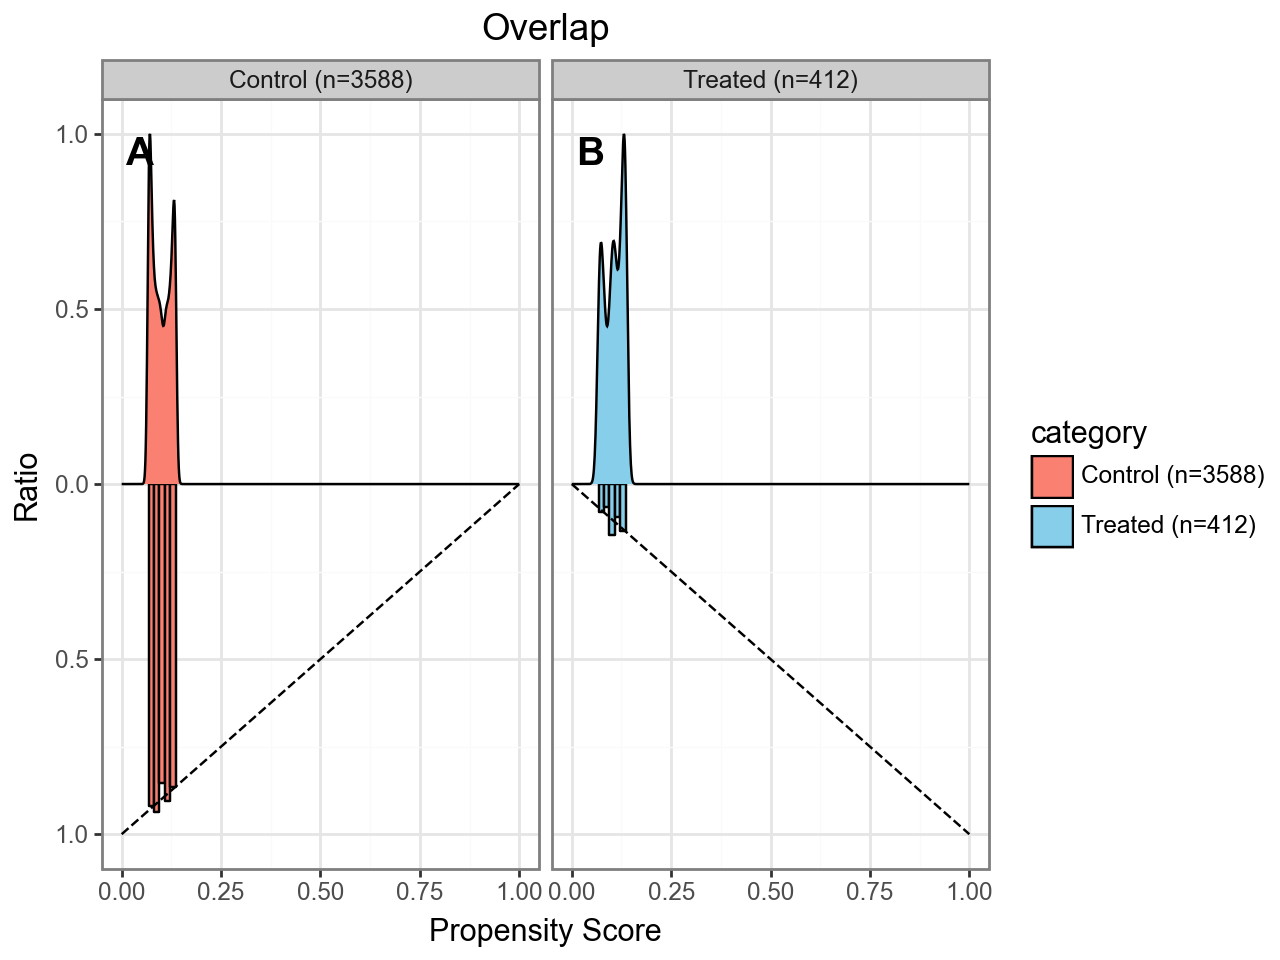

In [30]:
plot_overlap_ratio_detailed(
    data=combined_df,
    ps_col='ps',
    treatment_col='treatment',
    metric='ratio',
    directory='results/figures_unb/ps_treatment_3/',
    n_obs=4000,  
    dim_x=dim_x,     
    learner_m='LGBM',
    learner_g='LGBM',
    clipping_threshold=1e-12,
    R2_d=0.0,     
    overlap=0.0, 
    share_treated=share_treated,
    n_bins=5
)